# Acute Lymphoblastic Leukemia 

**Authors:** Chris John, Erica Robeen, Mauricio Perez, Simran Gill   
**Class:** Datasci 207 - Machine Learning

Leukemia is a type of cancer that affects the blood and bone marrow. This causes the body to producee too much adnormal white blood cells. These cells cannot fight infections and prevent bone marrow from poducing healthy red blood cells and platelets. 

Acute lymphoblastic leukemia is one of the most common type of childhood cancers, totaling up to 25% of pediatric cancers. Identifying leukemic cells from normal cells nuder the microscope can be challenging becuase of the morphological similarities.


**Task:** Using image classification model, identify normal cells from cancer cells. 

**Data Source:** https://www.kaggle.com/datasets/andrewmvd/leukemia-classification

#### ``Objectives``
1. Implement a Convolutional Nural Network (CNN) model to detect leukemic cells from microscopic cell images.
2. Improve generalization performance and reduce overfitting using image transformation and data augmentation techniques.

#### ``Motivation``
Leukemia is a type of cancer that affects the blood and bone marrow, often characterized by abnormal white blood cell production. Early and accurate detection of leukemia through microscopic examination of blood samples is critical for timely treatment and improved patient outcomes. Automating this process with machine learning models can enhance diagnostic efficiency and accessibility, benefiting patients and healthcare systems.

---
### Step 1: Import libraries

In [1]:
import numpy as np
import pandas as pd
import random

# tf and keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras import models
from keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D

# sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Undersampling 
from imblearn.under_sampling import RandomUnderSampler

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Set random seed for reproducibility
random.seed(2)
%matplotlib inline

import os
import zipfile

TRAIN_DATA_PATH = "./C-NMC_Leukemia/training_data"
VAL_DATA_PATH = "./C-NMC_Leukemia/validation_data"


---
### Step 2: Downloading Data
* Combining training and validation set because kaggle does not provide the labels for the test set. 
* After combining, will split the data into train, test, and validation

In [29]:
# Downloading Data
'''
archive = zipfile.ZipFile('archive.zip', 'r')

# training 
for file in archive.namelist():
    if file.startswith('C-NMC_Leukemia/training_data/'):
        archive.extract(file, './')
# validation
for file in archive.namelist():
    if file.startswith('C-NMC_Leukemia/validation_data'):
        archive.extract(file, './')
'''


"\narchive = zipfile.ZipFile('archive.zip', 'r')\n\n# training \nfor file in archive.namelist():\n    if file.startswith('C-NMC_Leukemia/training_data/'):\n        archive.extract(file, './')\n# validation\nfor file in archive.namelist():\n    if file.startswith('C-NMC_Leukemia/validation_data'):\n        archive.extract(file, './')\n"

In [2]:
def load_data(path_to_data,data_type, target_size=(128, 128) ):
    '''Load 2D images and their corresponding labels
    Parameters:
    path_to_data (str): This is the path to data
    data_type (str): This tells us the type of dataset in path_to_data
    target_size (int,int): target size of images

    Returns:
    images (np.ndarray): A numpy array of shape (N, 224, 224, 3)
    labels (np.ndarray): A numpy array of shape (N)
    
    '''
    # also resizing images to help with reducing computational load
    # without resizing, takes up too much memory
    images = []
    labels = []

    l = os.listdir(path_to_data)

    # Training data
    if data_type == 'train':
        for fold in l:
            fold_path = os.path.join(path_to_data, fold)

            for label in os.listdir(fold_path):
                label_path = os.path.join(fold_path, label)

                image_file = os.listdir(label_path)
                for image in image_file:
                    image_path = os.path.join(label_path,image,)
                    img = load_img(image_path, color_mode="rgb", target_size = target_size)
                    images.append(img)
                    labels.append(label)
        labels = [1 if i == 'all' else  0 for i in labels]
        
    # Validation 
    if data_type == 'val':
        for val in l:
            if val == 'C-NMC_test_prelim_phase_data':
                val_path = os.path.join(path_to_data, val)
                image_file = os.listdir(val_path)
                for image in image_file:
                    image_path = os.path.join(val_path,image)
                    img = load_img(image_path, color_mode="rgb", target_size = target_size)
                    images.append(img)
            else:
                filename = path_to_data+ "/"+ val
                print(filename)
                df = pd.read_csv(filename)
                labels = df['labels'].to_list()
    
    images = np.array(images)
    labels = np.array(labels)

    return images, labels


In [3]:
# Leukemia Data
images1, labels1 = load_data(TRAIN_DATA_PATH, "train")
images2, labels2 = load_data(VAL_DATA_PATH, "val")

images = np.concatenate((images1,images2), axis = 0)
labels = np.concatenate((labels1,labels2), axis = 0)

# --- Summary of Dataset ---
print(f"Full Dataset: {images.shape}, Labels: {labels.shape}")


./C-NMC_Leukemia/validation_data/C-NMC_test_prelim_phase_data_labels.csv
Full Dataset: (12528, 128, 128, 3), Labels: (12528,)


--- 
### Step 3: Exploratory Data Analysis (EDA)
Plot a histogram to visualize the distribution of the two classes in the leukemia dataset: 'Healthy (hem)' and 'Cancer (all)'. The bar plot displays the total number of samples for each class across the combined training and validation datasets.

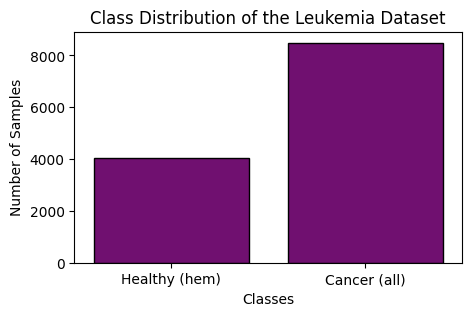

In [4]:
class_counts = np.bincount(labels)
class_names = ['Healthy (hem)', 'Cancer (all)']

# Plot the histogram
plt.figure(figsize=(5, 3))  # Define the figure size only once
sns.barplot(x=class_names, y=class_counts, color = 'purple', edgecolor = 'black')
plt.title('Class Distribution of the Leukemia Dataset')
plt.ylabel('Number of Samples')
plt.xlabel('Classes')
plt.show()

**Comment on class balance:** 
The classes are not too balanced with roughly 2x more cancer (all) samples compared to healthy (hem). It's not realistic that it would reflect the population as a whole, although could reflect the population sent for testing.

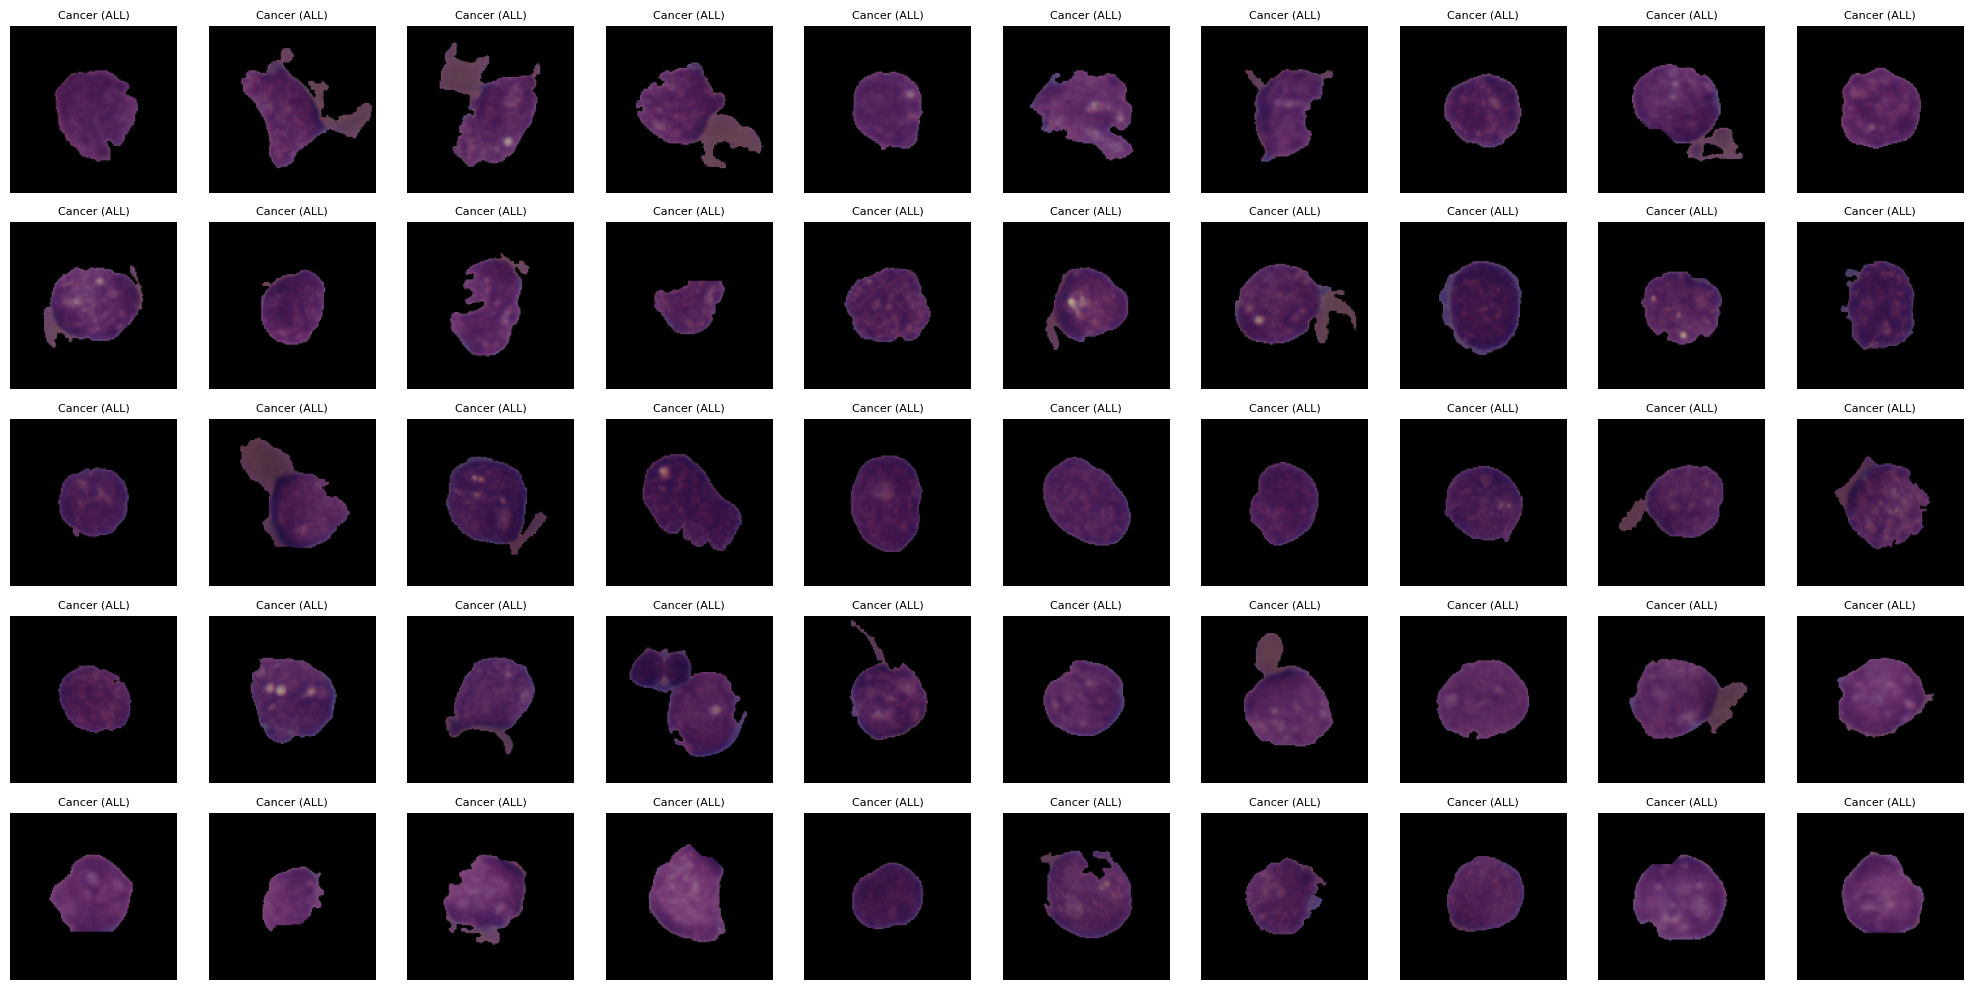

In [5]:
# --- Printing 50 images from the data.---

#using an LLM to assist with coding

# Number of images to display
num_images = 50

# Create a figure to display the images
plt.figure(figsize=(20, 10)) 

for i in range(num_images):
    image = images[i]
    label = 'Cancer (ALL)' if labels[i] == 1 else 'Healthy (HEM)'
    
    # Add a subplot in a 5x10 grid
    plt.subplot(5, 10, i+1)  # 5 rows, 10 columns
    plt.imshow(image)
    plt.title(label, fontsize=8)
    plt.axis('off')

plt.tight_layout()
plt.show()

**Comment on the size, focus/orientation of the 50 images:**
* Size: the images all seem to be the same pixels
* Focus: The images have clear cell boundaries and good focus with some boundary abnormalities visible.  The orientation is difficult to assess, but the results still may be better with data augmentation to help.

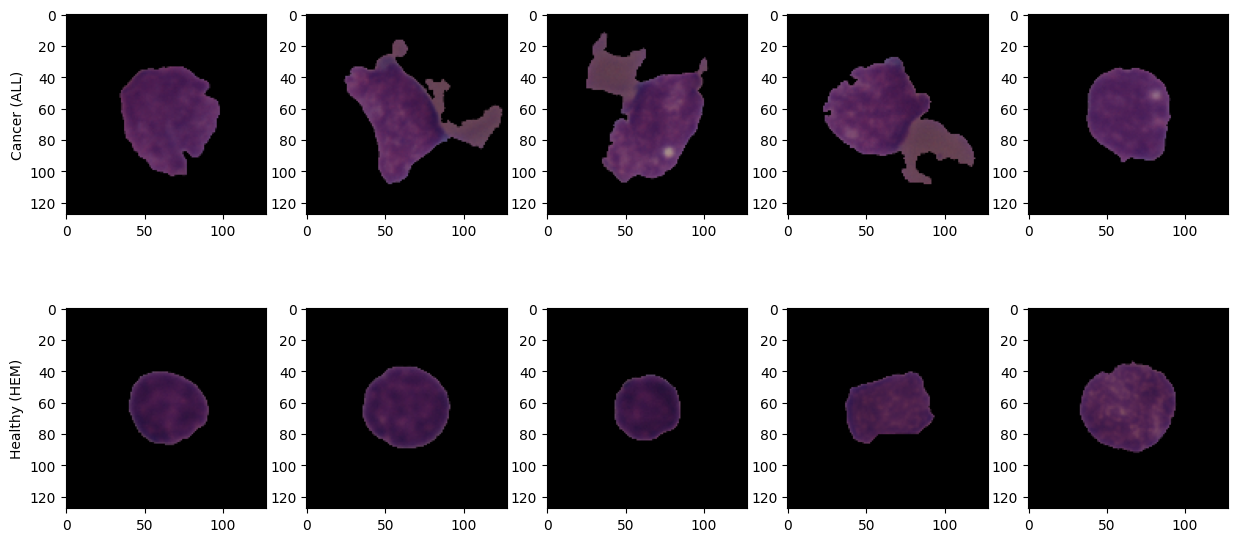

In [6]:
#---First 5 images for each class---

label_names = [1, 0]
class_leukemia = {i: [] for i in label_names}
for  index, value in enumerate(labels):
    if len(class_leukemia[value]) < 5:
        class_leukemia[value].append(images[index])
    if all(len(images) == 5 for images in class_leukemia.values()):
        break

# ploting 5 images per class
fig, axes = plt.subplots(2,5, figsize = (15, 7))
for label_index in range(len(label_names)):
    for image_index in range(5):
        ax = axes[label_index, image_index]
        ax.imshow(class_leukemia[label_names[label_index]][image_index])
        if image_index == 0:
            if label_names[label_index] == 1:
                ax.set_ylabel("Cancer (ALL)")
            else:
                ax.set_ylabel("Healthy (HEM)")

**Characteristic of Classes:** Considerig the small sample dislayed,Cancer(ALL) class cells come in various shapes with some having a small white dot on the cell. When it comes to the Healthy (HEM) class, most are close to being a circle with no white dot.  

---
### Step 4: Data Preprocessing 
Rescaling images by dividing each pixal by 255.0. This helps with scaling the values to a range of 0 to 1, wich makes the data more suitable for ML models especially when it comes to CNN.

From the histogram above, we can see there is an imbalance in labels. There are more cancer cells than healthy cells. '
https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/
* By undersampling we are can help prevent model bias towards majority class. This helps with imporving learning for minority class.




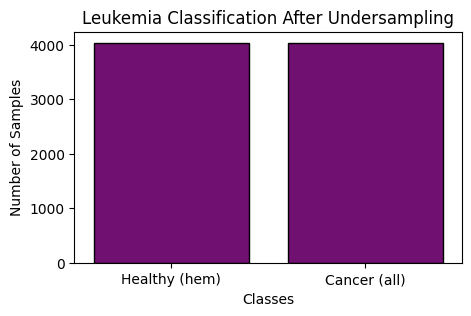

In [7]:
# --Undersampling majority and Normalizing--

# rescaling data by dividing each pixal by 255.0
images = images.astype('float32') / 255.0
# reshaping numpy array
num_samples, height, width, channels = images.shape
images_reshaped = images.reshape(num_samples, -1)
# applying undersampling
undersample = RandomUnderSampler(sampling_strategy='majority')
images_mini, labels_mini = undersample.fit_resample(images_reshaped, labels)
# reshaping images back to 3D
num_samples_mini = images_mini.shape[0]
images_mini_reshaped = images_mini.reshape(num_samples_mini, height, width, channels)

# After undersampling bar graph
class_counts = np.bincount(labels_mini)
class_names = ['Healthy (hem)', 'Cancer (all)']
plt.figure(figsize=(5, 3)) 
sns.barplot(x=class_names, y=class_counts, color = 'purple', edgecolor = 'black')
plt.title("Leukemia Classification After Undersampling")
plt.ylabel('Number of Samples')
plt.xlabel('Classes')
plt.show()

### Split Data into Train, Test, Validation

Prepare training, validation, and test datasets with lazy loading and on-the-fly transformations for the leukemia classification task. The goal of the function is to ensure the model has balanced data for train, validation, and test, while leveraging augmentation to improve generalization.  Lazy loading is utilized to help process the large dataset by processing on demand.

Data Splitting:
Shuffle images and labels before splitting to ensure randomness.
Divide the dataset into training, validation, and test sets using a (0.6, 0.2, 0.2) split ratio.

Lazy Loading:
Convert data into TensorFlow datasets (tf.data.Dataset) for efficient processing.
Batch and prefetch the data to optimize pipeline performance during model training.

Data Augmentation:
Augment the training data with horizontal flips using TensorFlow's tf.image module to improve generalization and prevent overfitting.
Note: Augmentation is applied only to the training dataset.

Data Preparation:
Rescale pixel values in all datasets to the range [0, 1] by dividing by 255.0.
Use batching and prefetching to speed up data loading and ensure efficient utilization of GPU/CPU during training.

In [21]:
'''def splitting_data(images, labels, splits):
    """ Split data into train, validation, and test set 
    Params:
    -------
    images (np.ndarray): Images of shape ...
    labels (np.ndarray): Labels of shape(N, )
    """
    np.random.seed(1234)

    # shuffle data
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]

    # create data splits (training, val, test)
    X_train, X_temp, y_train, Y_temp = train_test_split(images, labels, test_size = (1 - splits[0]), random_state = 1234)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=splits[2]/(splits[1]+splits[2]), random_state=1234)

    return X_train, y_train, X_val, y_val, X_test, y_test'''

'def splitting_data(images, labels, splits):\n    """ Split data into train, validation, and test set \n    Params:\n    -------\n    images (np.ndarray): Images of shape ...\n    labels (np.ndarray): Labels of shape(N, )\n    """\n    np.random.seed(1234)\n\n    # shuffle data\n    indices = np.arange(len(labels))\n    np.random.shuffle(indices)\n    images = images[indices]\n    labels = labels[indices]\n\n    # create data splits (training, val, test)\n    X_train, X_temp, y_train, Y_temp = train_test_split(images, labels, test_size = (1 - splits[0]), random_state = 1234)\n    X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=splits[2]/(splits[1]+splits[2]), random_state=1234)\n\n    return X_train, y_train, X_val, y_val, X_test, y_test'

In [ ]:
def splitting_data(images, labels, splits = (0.6,0.2,0.2), batch_size = 32):
    """
    Split data into train, validation, and test sets; apply on-the-fly transformations and lazy loading.

    Params:
    -------
    images (np.ndarray): Images of shape (N, H, W, C).
    labels (np.ndarray): Labels of shape (N,).
    splits (tuple): Proportions for train, validation, and test sets (must sum to 1).
    batch_size (int): Batch size for data generators.

    Returns:
    --------
    train_dataset (tf.data.Dataset): Dataset for training (with augmentation).
    val_dataset (tf.data.Dataset): Dataset for validation.
    test_dataset (tf.data.Dataset): Dataset for testing.
    """

    # Shuffle data
    indices = np.arange(len(labels))
    np.random.shuffle(indices)
    images = images[indices]
    labels = labels[indices]

    # Split data into train, validation, and test sets
    X_train, X_temp, y_train, Y_temp = train_test_split(images, labels, test_size=(1 - splits[0]), random_state=1234)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, Y_temp, test_size=splits[2]/(splits[1] + splits[2]), random_state=1234)

    # Image augmentation (random flip) on training data
    X_train_augm = np.array([tf.image.random_flip_left_right(img).numpy() for img in X_train])
    X_train = np.concatenate([X_train, X_train_augm])
    # Concatenate y_train (note the label is preserved)
    y_train_augm = y_train
    y_train = tf.concat([y_train, y_train_augm], axis=0)
    
    # Create datasets
    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

    # Shuffle and batch datasets
    train_dataset = train_dataset.shuffle(1000).batch(batch_size).prefetch(tf.data.AUTOTUNE)
    val_dataset = val_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    test_dataset = test_dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

    return train_dataset, val_dataset, test_dataset

In [ ]:
split = (0.6, 0.2, 0.2)
batch_size = 32
train_dataset, val_dataset, test_dataset = splitting_data(
    images_mini_reshaped,
    labels_mini,
    splits=split,
    batch_size=batch_size
)

---
### Step 5: Base Model

The objective of this code is to build and train a Convolutional Neural Network (CNN) model to classify leukemia cell images into two categories: healthy (hem) and cancerous (all). This binary classification can assist in automating the process of distinguishing cancerous cells from healthy ones, thereby supporting early detection and diagnosis of leukemia.

The code implements a CNN classifier as follows:

1. The model is implemented using TensorFlow's Keras API.
2. The model accepts input images of size 224 x 224 x 3 (RGB format, three color channels).
3. The first layer is a convolutional layer with the following specifications::
    - filters = 12
    - kernel_size = (4 x 4)
    - strides = (1, 1)
    - padding = 'same'
    - data_format = 'channels_last'
    - name = 'conv_1'
    - activation = 'relu'
4. Max-pooling Layer: The convolutional layer is followed by a max-pooling layer with pool_size = (2,2). This reduces the spatial dimensions of the feature maps, thereby decreasing computational complexity while retaining key features.
5. Dropout Layer: The max-pooling layer is followed by a dropout layer with rate = 0.3 to prevent overfitting by randomly deactivating 30% of neurons during training. 
6. Flattening Layer: The feature maps are flattened into a 1D array to prepare the data for the fully connected layer.
7. Classification Layer: The final layer is a dense layer with one neuron and a sigmoid activation function which outputs the probability of the image belonging to the cancerous category.
8. Model Compilation: The model is compiled as follows:
    - Optimizer: Adam optimizer with a learning rate of 0.1
    - Loss function: Binary crossentropy for binary classification
    - Metrc: Accuracy
    - Training: The model is trained for up to 20 epochs using the train_dataset and validated on the val_dataset.  An eary stopping mechanism is utilized to halt training when the validation loss stops improving for 5 consecutive epochs.
9. A plot is generated of training and validation loss over epochs to visualize the learning process.
10. Evaluation: The model's accuracy and loss are evaluated on both the training and validation data sets providing important insight into the model's performance.  

In [10]:
# Define early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', 
    patience=5, 
    verbose=1,
    mode='min', 
    restore_best_weights=True
)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 128, 128, 12)   │           588 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 12)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 49152)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │        49,153 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,741 (194.30 KB)

 Trainable params: 49,741 (194.30 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 29ms/step - accuracy: 0.6309 - loss: 3.6128 - val_accuracy: 0.4854 - val_loss: 0.6945
Epoch 2/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 11s 35ms/step - accuracy: 0.4985 - loss: 0.6951 - val_accuracy: 0.5146 - val_loss: 0.6940
Epoch 3/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 33ms/step - accuracy: 0.5009 - loss: 0.6954 - val_accuracy: 0.5146 - val_loss: 0.6927
Epoch 4/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.5001 - loss: 0.6954 - val_accuracy: 0.5146 - val_loss: 0.6927
Epoch 5/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 34ms/step - accuracy: 0.4998 - loss: 0.6952 - val_accuracy: 0.5146 - val_loss: 0.6929
Epoch 6/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 8s 27ms/step - accuracy: 0.5097 - loss: 0.6952 - val_accuracy: 0.5146 - val_loss: 0.6933
Epoch 7/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 9s 29ms/step - accuracy: 0.4953 - loss: 0.6954 - val_accuracy: 0.5146 - val_loss: 0.6930
Epoch 8/20
303/303 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.4834 - loss: 0.6957 - va

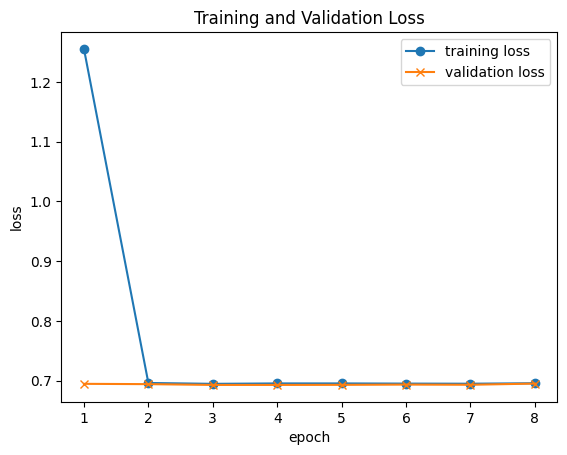

Training Accuracy: 0.4922
Validation Accuracy: 0.5146


In [12]:
# Set random seeds for reproducibility
tf.random.set_seed(1234)
np.random.seed(1234)

# Initialize the model
model_tf = tf.keras.Sequential()

# Add convolutional layer
model_tf.add(tf.keras.layers.Conv2D(
    filters=12,
    kernel_size=(4, 4),
    strides=(1, 1),
    padding='same',
    data_format='channels_last',
    activation='relu',
    name='conv_1'
))

# Add max pooling layer
model_tf.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Add dropout layer
model_tf.add(tf.keras.layers.Dropout(rate=0.3))

# Add flattening layer
model_tf.add(tf.keras.layers.Flatten())

# Add classification layer
model_tf.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Build and compile the model
model_tf.build(input_shape=(None, 128, 128, 3))
model_tf.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

# Print the model summary
model_tf.summary()

# Train the model
history = model_tf.fit(
    train_dataset,  
    validation_data=val_dataset, 
    epochs=20,
    callbacks=[early_stopping]
)

# Plot loss curves
x_arr = np.arange(len(history.history['loss'])) + 1
plt.plot(x_arr ,history.history['loss'], '-o', label='training loss')
plt.plot(x_arr ,history.history['val_loss'], '-x', label='validation loss')
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Evaluate the model on training and validation data
train_loss, train_accuracy = model_tf.evaluate(train_dataset, verbose=0)
val_loss, val_accuracy = model_tf.evaluate(val_dataset, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")



How many parameters does model_tf have? 49,741 parameters

Comment on model_tf accuracy on training vs. validation data: The training accuracy is 0.4922 verses the validation accuracy of 0.5146. This is close to just random guessing and not great performance. The values are similar vetween accuracy and validation, which could suggest underfitting.

Build and train a Convolutional Neural Network (CNN) to classify leukemia images into two categories: 'Healthy (hem)' and 'Cancer (all)'. This binary classification task aims to identify cancerous samples for further medical evaluation.

---
### Step 6: Modifying Model

Here we are attempting to improve the model from the base model by:
* Applying additional Data augmentation layers 
* Three Convolutional blocks
* Dense hidden layer 

C:\Users\simran\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ random_rotation                 │ (None, 128, 128, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom (RandomZoom)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_brightness               │ (None, 128, 128, 3)    │             0 │
│ (RandomBrightness)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_1 (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │     4,194,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,287,809 (16.36 MB)

 Trainable params: 4,287,809 (16.36 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 67s 213ms/step - accuracy: 0.5037 - loss: 1.1764 - val_accuracy: 0.4854 - val_loss: 0.7003
Epoch 2/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - accuracy: 0.5108 - loss: 0.7598 - val_accuracy: 0.4854 - val_loss: 0.6970
Epoch 3/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - accuracy: 0.5077 - loss: 0.7602 - val_accuracy: 0.4854 - val_loss: 0.6935
Epoch 4/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 64s 212ms/step - accuracy: 0.5079 - loss: 0.7620 - val_accuracy: 0.4854 - val_loss: 0.6935
Epoch 5/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 64s 213ms/step - accuracy: 0.5061 - loss: 0.7606 - val_accuracy: 0.4854 - val_loss: 0.6927
Epoch 6/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 66s 217ms/step - accuracy: 0.5064 - loss: 0.7579 - val_accuracy: 0.4854 - val_loss: 0.6854
Epoch 7/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 68s 225ms/step - accuracy: 0.5041 - loss: 0.7592 - val_accuracy: 0.4854 - val_loss: 0.6708
Epoch 8/15
303/303 ━━━━━━━━━━━━━━━━━━━━ 102s 338ms/step - accuracy: 0.5072 - loss: 

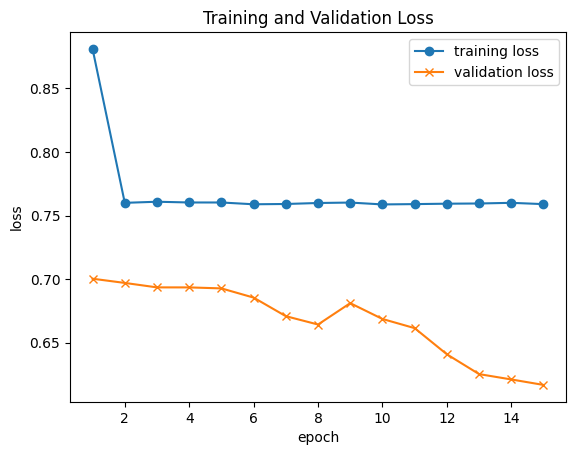

Training Accuracy: 0.7258
Validation Accuracy: 0.6966


In [ ]:
# Initialize the fine-tuned model
model_fine_tuned = tf.keras.Sequential()

# Data augmentation layers
model_fine_tuned.add(tf.keras.layers.RandomRotation(factor=0.1, input_shape=(128, 128, 3)))
model_fine_tuned.add(tf.keras.layers.RandomZoom(height_factor=0.1, width_factor=0.1))
model_fine_tuned.add(tf.keras.layers.RandomBrightness(factor=0.2))
model_fine_tuned.add(tf.keras.layers.RandomFlip(mode="horizontal"))

# Define class weights to address class imbalance
class_weight = {0: 1.0, 1: 1.2}

# First convolutional block
model_fine_tuned.add(tf.keras.layers.Conv2D(
    filters=32,  # Increased filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_1'
))
model_fine_tuned.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Second convolutional block
model_fine_tuned.add(tf.keras.layers.Conv2D(
    filters=64,  # Increased filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_2'
))
model_fine_tuned.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Third convolutional block
model_fine_tuned.add(tf.keras.layers.Conv2D(
    filters=128,  # Further increased filters
    kernel_size=(3, 3),
    strides=(1, 1),
    padding='same',
    activation='relu',
    name='conv_3'
))
model_fine_tuned.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# Dropout layer to prevent overfitting
model_fine_tuned.add(tf.keras.layers.Dropout(rate=0.5))

# Flatten layer
model_fine_tuned.add(tf.keras.layers.Flatten())

# Dense hidden layer
model_fine_tuned.add(tf.keras.layers.Dense(128, activation='relu', name='dense_1'))
model_fine_tuned.add(tf.keras.layers.Dropout(rate=0.4))  # Increased dropout

# Classification layer
model_fine_tuned.add(tf.keras.layers.Dense(1, activation='sigmoid'))

# Build and compile the model with an adjusted learning rate
model_fine_tuned.build(input_shape=(None, 128, 128, 3))
model_fine_tuned.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),  # Higher learning rate
                 loss=tf.keras.losses.BinaryCrossentropy(),
                 metrics=['accuracy'])

# Print the model summary
model_fine_tuned.summary()

# Train the model with class weights
history = model_fine_tuned.fit(
    train_dataset,  # Lazy-loaded dataset
    validation_data=val_dataset,  # Lazy-loaded dataset
    epochs=25,
    class_weight=class_weight,  # Address class imbalance
    callbacks=[early_stopping]
)

# Plot loss curves
x_arr = np.arange(len(history.history['loss'])) + 1
plt.plot(x_arr ,history.history['loss'], '-o', label='training loss')
plt.plot(x_arr ,history.history['val_loss'], '-x', label='validation loss')
plt.title("Training and Validation Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# Evaluate the model on training and validation datasets
train_loss, train_accuracy = model_fine_tuned.evaluate(train_dataset, verbose=0)
val_loss, val_accuracy = model_fine_tuned.evaluate(val_dataset, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

---
### Step 7: Evaluate 

Use test data to evaluate the performance (accuracy) of your fine-tuned model on unseen data. Does your model generalize well?

In [14]:
test_loss, test_accuracy = model_fine_tuned.evaluate(test_dataset, verbose=0)

# Print the test accuracy
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Check if the model generalizes well
if test_accuracy > val_accuracy - 0.05:  # Example: Allow a 5% drop from validation accuracy
    print("The model generalizes well to unseen data.")
else:
    print("The model does not generalize well. Consider further fine-tuning or regularization.")

Test Loss: 0.6022
Test Accuracy: 0.7158
The model generalizes well to unseen data.


51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step
Precision Cancer (all): 0.6640
Recall Cancer (all): 0.8525


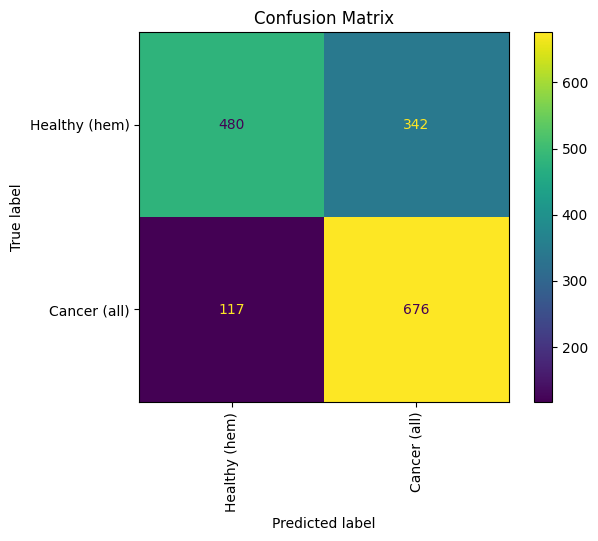

In [25]:
# extracting y_test labels
y_test = np.concatenate([y.numpy() for _, y in test_dataset])

# predictions for test set 
y_test_pred_prob = model_fine_tuned.predict(test_dataset) 
y_test_pred = (y_test_pred_prob > 0.5).astype(int).flatten()

# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels = ['Healthy (hem)', 'Cancer (all)'])
disp.plot()
plt.xticks(rotation='vertical')
plt.title("Confusion Matrix")

# Recall and Percision
tn, fp, fn, tp = cm.ravel()

# Precision is the proportion of true positives out of both true positives and false positives.
precision = tp / (tp + fp)

# Recall is the proportion of true positives out of true positives + false negatives.
recall = tp / (tp + fn)

print(f"Precision Cancer (all): {precision:.4f}")
print(f"Recall Cancer (all): {recall:.4f}")